<a href="https://colab.research.google.com/github/rayshu/Data-Classification/blob/master/USCongress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# import packages

In [0]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, svm
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.feature_selection import chi2
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

In [0]:
df = pd.read_csv("/content/drive/My Drive/Data/usCongressClean.csv")
np.random.seed(1000)

In [4]:
df_ent = df.loc[(df['DocType']=="Public") | (df["DocType"]=="Private"),:]
df_ent.loc[:,'DocType_id'] = df_ent['DocType'].map({"Public":0, "Private":1})
df_ent

,Text,DocType,DocType_id
0,amend federal water pollution control act esta...,Public,0
1,amend public health service act establish gran...,Public,0
2,authorize secretary education make grant eligi...,Public,0
3,authorize secretary interior conduct study ass...,Public,0
4,redesignate weir farm national historic site s...,Public,0
...,...,...,...
1365,base upon groundbreaking supreme court decisio...,Private,1
1366,event cr report number r author k alan kronsta...,Private,1
1367,homeland security intelligence perception stat...,Private,1
1368,e amend cr report number author harold c relye...,Private,1


In [5]:
df_nent = df.loc[df["DocType"]=="NE",:]
df_nent.loc[:,'DocType_id'] = df_nent['DocType'].map({"NE":0})
df_nent

,Text,DocType,DocType_id


## data distribution

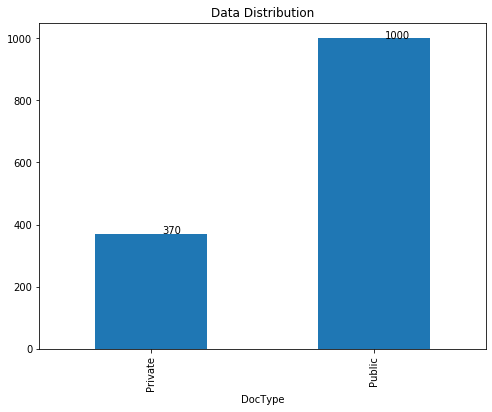

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
graph = df.groupby('DocType').Text.count().plot.bar(ylim=0)

for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))
graph.set_title('Data Distribution') 
plt.show()

# Training Data

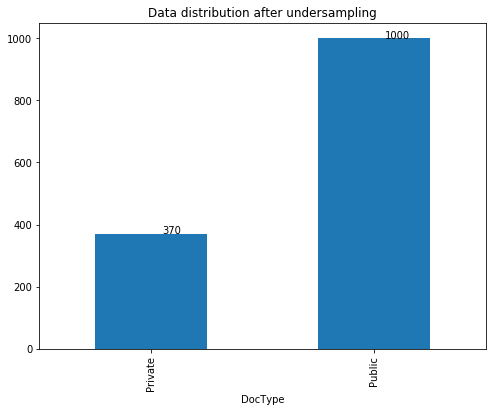

In [7]:
fig = plt.figure(figsize=(8,6))
graph = df_ent.groupby('DocType').Text.count().plot.bar(ylim=0)

for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()))
graph.set_title('Data distribution after undersampling') 
plt.show()

In [0]:
doctype_to_id = {'DocType':["Public", "Private"], 'doctype_id': [0, 1]} 
doctype_id_df = pd.DataFrame(doctype_to_id) 

## Train Test Split

In [9]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(df_ent['Text'],df_ent['DocType_id'],test_size=0.2)
print('Train_X: ', Train_X.shape[0])
print('Train_Y: ', Train_Y.shape[0])
print('Test_X :  ', Test_X.shape[0])
print('Test_Y :  ', Test_Y.shape[0])

Train_X:  1096
Train_Y:  1096
Test_X :   274
Test_Y :   274


In [10]:
Train_counts = pd.DataFrame(Train_Y.values, columns = list('a'))
print('Train Data Distribution')
print(Train_counts['a'].value_counts())

Test_counts = pd.DataFrame(Test_Y.values, columns = list('a'))
print('\n\nTest Data Distribution')
print(Test_counts['a'].value_counts())

Train Data Distribution
0    803
1    293
Name: a, dtype: int64


Test Data Distribution
0    197
1     77
Name: a, dtype: int64


## tf-idf Vectors

In [11]:
# Tfidf_vect = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='ISO-8859-1', ngram_range=(1, 2))
Tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
#Learn the vocabulary
Tfidf_vect.fit(df_ent['Text'])

Train_X_Tfidf = Tfidf_vect.transform(Train_X)
print("Train Data (Text, Features):", Train_X_Tfidf.shape)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)
print("Test Data (Text, Features):", Test_X_Tfidf.shape)

# Test_X_Tfidf_Nent = Tfidf_vect.transform(df_nent['Text'])
# print("Wikipedia Data (Text, Features):", Test_X_Tfidf_Nent.shape)
# Test_Y_Nent = df_nent['DocType_id']

Train Data (Text, Features): (1096, 26863)
Test Data (Text, Features): (274, 26863)


### Top tf-idf features

In [12]:
df_public = df_ent.loc[df_ent["DocType"]=="Public",:]
df_private = df_ent.loc[df_ent["DocType"]=="Private"]
features_public = Tfidf_vect.fit_transform(df_public.Text)
features_private = Tfidf_vect.fit_transform(df_private.Text)
labels_public = df_public.DocType_id
labels_private = df_private.DocType_id
print("Features for public train data", features_public.shape)
print("Features for private train data", features_private.shape)

Features for public train data (1000, 5827)
Features for private train data (370, 22226)


In [13]:
N = 20

#Public data
features_public = Tfidf_vect.fit_transform(df_public.Text)
feature_names = np.array(Tfidf_vect.get_feature_names())
tfidf_sorting = np.argsort(features_public.toarray()).flatten()[::-1]
top_public = feature_names[tfidf_sorting][:N]
# print(Tfidf_vect.vocabulary_)
print('# Public')
print(". {}".format('\n. '.join(top_public)))

# features_public_dict = {}
# for key in sorted(Tfidf_vect.vocabulary_.keys()):
#     # print (key, Tfidf_vect.vocabulary_[key])
#     features_public_dict.update( {key : Tfidf_vect.vocabulary_[key]} )

# Public
. percent act
. percent
. act
. export act
. experience act
. explanation
. explanation benefit
. exploit
. exploit child
. exploitation
. exploitation act
. export
. zvarychuk
. expense purpose
. export clean
. export credit
. export finance
. exposure
. exposure protection
. exposure relate


In [14]:
#Private data
features_private = Tfidf_vect.fit_transform(df_private.Text)
feature_names = np.array(Tfidf_vect.get_feature_names())
tfidf_sorting = np.argsort(features_private.toarray()).flatten()[::-1]
top_private = feature_names[tfidf_sorting][:N]
# print(Tfidf_vect.vocabulary_)
# features_private_dict = {'Features':Tfidf_vect.vocabulary_.keys(), 'Values': Tfidf_vect.vocabulary_.values()} 
print('\n# Private')
print(". {}".format('\n. '.join(top_private)))
# features_private_dict


# Private
. event
. security event
. special security
. national special
. nsse
. designate
. special
. usss
. security
. lead
. major
. national
. presidential
. funding
. president representative
. major sport
. meeting secret
. sport event
. designate event
. major event


## Top 10 features for SVM classifier

In [15]:
clf = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=0)
clf.fit(Train_X_Tfidf,Train_Y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

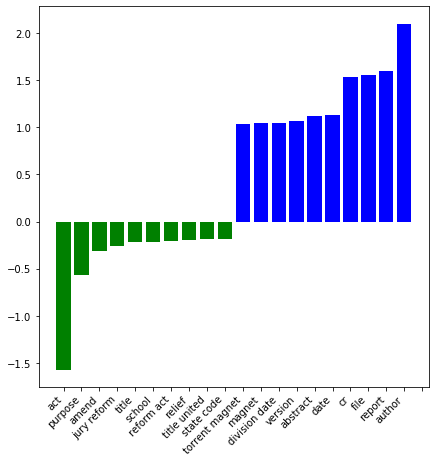

In [16]:

N = 10
Tfidf_vect.fit(df_ent['Text'])
def feature_plot(classifier, feature_names, top_features=N):
 coef = classifier.coef_.toarray()[0]
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 plt.figure(figsize=(7, 7))
 colors = ['green' if c < 0 else 'blue' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(1 + 2 * top_features), feature_names[top_coefficients], rotation=45, ha='right')
 plt.show()

#  print("Most corelated terms: \n. {}".format('\n'.join(feature_names[top_coefficients])))
#  unigrams = [v for v in feature_names[top_coefficients] if len(v.split(' ')) == 1]
#  bigrams = [v for v in feature_names[top_coefficients] if len(v.split(' ')) == 2]
#  print("Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[:N])))
#  print("Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

feature_plot(clf, Tfidf_vect.get_feature_names())


# Model Selection

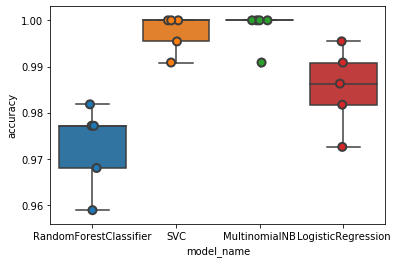

In [17]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    # LinearSVC(),
    svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',random_state=0),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, Train_X_Tfidf, Train_Y, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [18]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.985392
MultinomialNB             0.998174
RandomForestClassifier    0.972619
SVC                       0.997260
Name: accuracy, dtype: float64

## Model Evaluation

RandomForestClassifier 
 [[197   0]
 [  6  71]]
SVC 
 [[197   0]
 [  0  77]]
MultinomialNB 
 [[197   0]
 [  0  77]]
LogisticRegression 
 [[197   0]
 [  3  74]]


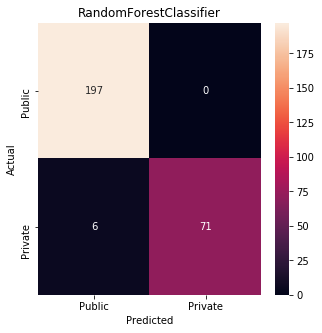

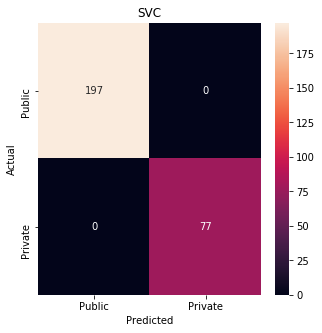

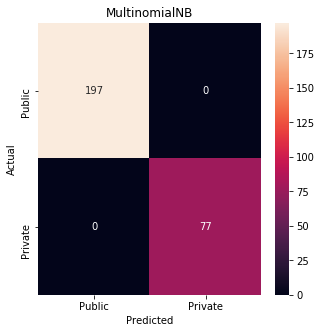

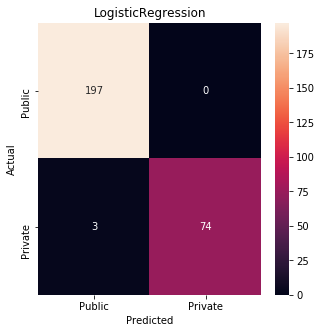

In [19]:
precision_public_list = []
precision_private_list = []
recall_public_list = []
recall_private_list = []
f1_public_list = []
f1_private_list = []

for model in models:   
    model_name = model.__class__.__name__
    model.fit(Train_X_Tfidf,Train_Y)
    predictions = model.predict(Test_X_Tfidf)
    conf_mat = confusion_matrix(Test_Y, predictions)
    
    print(model_name, '\n', conf_mat)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=doctype_id_df.DocType.values, yticklabels=doctype_id_df.DocType.values)
    plt.title(model_name)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    # fig.savefig('/content/drive/My Drive/Data/' + model_name + '.png')
    True_private = conf_mat[0,0]
    False_private = conf_mat[0,1]
    False_public = conf_mat[1,0]
    True_public = conf_mat[1,1]

    precision_private = round((True_private) / (True_private + False_private), 2)
    recall_private = round((True_private) / (True_private + False_public), 2)
    f1_private = round((2 * precision_private * recall_private) / (precision_private + recall_private), 2)

    precision_public = round((True_public) / (True_public + False_public), 2)
    recall_public = round((True_public) / (True_public + False_private), 2)
    f1_public = round((2 * precision_public * recall_public)/(precision_public + recall_public), 2)


    #writing to list
    precision_private_list.append(precision_private)
    recall_private_list.append(recall_private)
    f1_private_list.append(f1_private)

    precision_public_list.append(precision_public)
    recall_public_list.append(recall_public)
    f1_public_list.append(f1_public)

In [20]:
dict = {'Model':["Random Forest", "Linear Support Vector Classifier", "Multinomial Naive Bayes", "Logistic Regression"], 
        'Precision (Public Class)': precision_public_list, 
        'Recall (Public Class)': recall_public_list,
        'F1 Score (Public Class)': f1_public_list,
        'Precision (Private Class)': precision_private_list,
        'Recall (Private Class)': recall_private_list,
        'F1 Score (Private Class)': f1_private_list
        } 
    
evaluation_df = pd.DataFrame(dict) 
evaluation_df

,Model,Precision (Public Class),Recall (Public Class),F1 Score (Public Class),Precision (Private Class),Recall (Private Class),F1 Score (Private Class)
0,Random Forest,0.92,1.0,0.96,1.0,0.97,0.98
1,Linear Support Vector Classifier,1.00,1.0,1.00,1.0,1.00,1.00
2,Multinomial Naive Bayes,1.00,1.0,1.00,1.0,1.00,1.00
3,Logistic Regression,0.96,1.0,0.98,1.0,0.98,0.99


* high precision + high recall = *class pefectly handled by model*
* high precision + low recall = *class can't detect the class but highly trustable when it does*
* low precision + high recall = *well detected class but it also include points of other class*
* low precision + low recall = *class poorly handled by the model* 